In [1]:
import os
# Set environment variable to suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from src.loading_data.get_data import load_cv_data
from src.cnn_emos.nn_forecast import CNNEMOS, CNNBaggingEMOS
from src.visualization.twcrpss_plot import make_twcrpss_plot
from src.visualization.brier_score import make_brier_skill_plot
from src.visualization.pit import make_cpit_diagram, comp_multiple_pit_scores
from src.visualization.reliability_diagram import make_reliability_and_sharpness
from src.visualization.plot_forecasts import plot_forecast_pdf_tf, plot_weight_mixture_cnns, plot_weight_mixture_bagging
from src.climatology.climatology import Climatology
from src.linreg_emos.emos import LinearEMOS
from src.loading_data.get_data import get_fold_is
from src.visualization.brier_score import make_bootstrap_brier

import sklearn

from scipy.stats import norm, truncnorm

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import optuna

### Loading all data

In [2]:
all_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

features_names_dict = {name: 1 for name in all_features}

features_names_dict['wind_speed'] = 15

ignore = ['229', '285', '323']

In [3]:
train_data0_original, test_data0_original, ignore = load_cv_data(0, features_names_dict)

data_load = train_data0_original.batch(32)

train_data0 = train_data0_original.batch(train_data0_original.cardinality())
test_data0 = test_data0_original.batch(test_data0_original.cardinality())

In [4]:
train_data1, test_data1_original, ignore = load_cv_data(1, features_names_dict)

train_data1 = train_data1.batch(train_data1.cardinality())

test_data1 = test_data1_original.batch(test_data1_original.cardinality())


train_data2, test_data2_original, ignore = load_cv_data(2, features_names_dict)

train_data2 = train_data2.batch(train_data2.cardinality())

test_data2 = test_data2_original.batch(test_data2_original.cardinality())


train_data3, test_data3_original, ignore = load_cv_data(3, features_names_dict)

train_data3 = train_data3.batch(train_data3.cardinality())

test_data3 = test_data3_original.batch(test_data3_original.cardinality())

### Loading Climatology

In [5]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/climatology/climatology_cv_0'

climatology = Climatology.load(folder)

### Loading All Linear Models

In [6]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_base'

with open(filepath, 'rb') as f:
    constant_weight_tn = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/extreme'

with open(filepath, 'rb') as f:
    sharp_sigmoid_weight_tn = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/intermediate'

with open(filepath, 'rb') as f:
    sigmoid_weight_am_tn_ln = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_cnn_weight'

with open(filepath, 'rb') as f:
    best_cnn_weight_tn = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_ml_tn_ln_cnn_weight'

with open(filepath, 'rb')as f:
    best_cnn_weight_am_tn_ln = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_indictor_weight'

with open(filepath, 'rb') as f:
    indicator_weight_tn = LinearEMOS(pickle.load(f))



filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_ln_indictor_weight'

with open(filepath, 'rb') as f:
    indicator_weight_ln = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_ln_crps'

with open(filepath, 'rb') as f:
    constant_weight_ln = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_gev_indictor_weight'

with open(filepath, 'rb') as f:
    indicator_weight_gev = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_gev_crps'

with open(filepath, 'rb') as f:
    constant_weight_gev = LinearEMOS(pickle.load(f))

all_linear_models_fold0 = {'LinEMOS Sigmoid Weight AM TN-LN': sigmoid_weight_am_tn_ln,
                           'LinEMOS Sharp Sigmoid Weight TN': sharp_sigmoid_weight_tn,
                           # 'LinEMOS Best CNN Weight TN': best_cnn_weight_tn,
                           'LinEMOS Indicator Weight TN': indicator_weight_tn,
                           'LinEMOS Constant Weight TN': constant_weight_tn,}

all_linear_models_without_constant_weight0  = {'LinEMOS Sigmoid Weight AM TN-LN': sigmoid_weight_am_tn_ln,
                                            'LinEMOS Sharp Sigmoid Weight TN': sharp_sigmoid_weight_tn,
                                            # 'LinEMOS Best CNN Weight TN': best_cnn_weight_tn,
                                            'LinEMOS Indicator Weight TN': indicator_weight_tn}

linear_models_different_distribution = {# 'LinEMOS Constant Weight LN': constant_weight_ln,
                                        'LinEMOS Indicator Weight LN': indicator_weight_ln,
                                        #'LinEMOS Constant Weight GEV': constant_weight_gev,
                                        'LinEMOS Indicator Weight GEV': indicator_weight_gev,
                                        'LinEMOS Indicator Weight TN': indicator_weight_tn,
}

linear_model_best_cnn_dict0 = {'LinEMOS Best CNN Weight TN': best_cnn_weight_tn}

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given parameters for Log Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution


In [7]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_analytical'

with open(filepath, 'rb') as f:
    emos_analytical = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_analytical2'

with open(filepath, 'rb') as f:
    emos_analytical2 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_analytical3'

with open(filepath, 'rb') as f:
    emos_analytical3 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_analytical4'

with open(filepath, 'rb') as f:
    emos_analytical4 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_sampling_1'

with open(filepath, 'rb') as f:
    emos_sampling1 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_sampling_2'

with open(filepath, 'rb') as f:
    emos_sampling2 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_sampling_3'

with open(filepath, 'rb') as f:
    emos_sampling3 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_sampling_4'

with open(filepath, 'rb') as f:
    emos_sampling4 = LinearEMOS(pickle.load(f))

sampling_based_models = {"Sampling Based 1": emos_sampling1,
                         "Sampling Based 2": emos_sampling2,
                         "Sampling Based 3": emos_sampling3,
                         "Sampling Based 4": emos_sampling4,
                         "Analytical 2": emos_analytical2,
                         "Analytical 3": emos_analytical3,
                         "Analytical 4": emos_analytical4}

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution


In [8]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_base1'

with open(filepath, 'rb') as f:
    constant_weight_tn1 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/extreme1'

with open(filepath, 'rb') as f:
    sharp_sigmoid_weight_tn1 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/intermediate1'

with open(filepath, 'rb') as f:
    sigmoid_weight_am_tn_ln1 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_cnn_weight1'

with open(filepath, 'rb') as f:
    best_cnn_weight_tn1 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_ml_tn_ln_cnn_weight1'

with open(filepath, 'rb')as f:
    best_cnn_weight_am_tn_ln1 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_indictor_weight1'

with open(filepath, 'rb') as f:
    indicator_weight_tn1 = LinearEMOS(pickle.load(f))

all_linear_models_fold1 = {'LinEMOS Constant Weight TN': constant_weight_tn1,
                           'LinEMOS Sigmoid Weight AM TN-LN': sigmoid_weight_am_tn_ln1,
                           'LinEMOS Sharp Sigmoid Weight TN': sharp_sigmoid_weight_tn1,
                           # 'LinEMOS Best CNN Weight TN': best_cnn_weight_tn1,
                           'LinEMOS Indicator Weight TN': indicator_weight_tn1}

all_linear_models_without_constant_weight1  = {'LinEMOS Sigmoid Weight AM TN-LN': sigmoid_weight_am_tn_ln1,
                                            'LinEMOS Sharp Sigmoid Weight TN': sharp_sigmoid_weight_tn1,
                                            # 'LinEMOS Best CNN Weight TN': best_cnn_weight_tn1,
                                            'LinEMOS Indicator Weight TN': indicator_weight_tn1}

linear_model_best_cnn_dict1 = {'LinEMOS Best CNN Weight TN': best_cnn_weight_tn1}

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution


In [9]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_base2'

with open(filepath, 'rb') as f:
    constant_weight_tn2 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/extreme2'

with open(filepath, 'rb') as f:
    sharp_sigmoid_weight_tn2 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/intermediate2'

with open(filepath, 'rb') as f:
    sigmoid_weight_am_tn_ln2 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_cnn_weight2'

with open(filepath, 'rb') as f:
    best_cnn_weight_tn2 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_ml_tn_ln_cnn_weight2'

with open(filepath, 'rb')as f:
    best_cnn_weight_am_tn_ln2 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_indictor_weight2'

with open(filepath, 'rb') as f:
    indicator_weight_tn2 = LinearEMOS(pickle.load(f))

all_linear_models_fold2 = {'LinEMOS Constant Weight TN': constant_weight_tn2,
                           'LinEMOS Sigmoid Weight AM TN-LN': sigmoid_weight_am_tn_ln2,
                           'LinEMOS Sharp Sigmoid Weight TN': sharp_sigmoid_weight_tn2,
                           # 'LinEMOS Best CNN Weight TN': best_cnn_weight_tn2,
                           'LinEMOS Indicator Weight TN': indicator_weight_tn2}

all_linear_models_without_constant_weight2  = {'LinEMOS Sigmoid Weight AM TN-LN': sigmoid_weight_am_tn_ln2,
                                            'LinEMOS Sharp Sigmoid Weight TN': sharp_sigmoid_weight_tn2,
                                            # 'LinEMOS Best CNN Weight TN': best_cnn_weight_tn2,
                                            'LinEMOS Indicator Weight TN': indicator_weight_tn2}

linear_model_best_cnn_dict2 = {'LinEMOS Best CNN Weight TN': best_cnn_weight_tn2}

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution


In [10]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_base3'

with open(filepath, 'rb') as f:
    constant_weight_tn3 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/extreme3'

with open(filepath, 'rb') as f:
    sharp_sigmoid_weight_tn3 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/intermediate3'

with open(filepath, 'rb') as f:
    sigmoid_weight_am_tn_ln3 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_cnn_weight3'

with open(filepath, 'rb') as f:
    best_cnn_weight_tn3 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_ml_tn_ln_cnn_weight3'

with open(filepath, 'rb')as f:
    best_cnn_weight_am_tn_ln3 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_indictor_weight3'

with open(filepath, 'rb') as f:
    indicator_weight_tn3 = LinearEMOS(pickle.load(f))

all_linear_models_fold3 = {'LinEMOS Constant Weight TN': constant_weight_tn3,
                           'LinEMOS Sigmoid Weight AM TN-LN': sigmoid_weight_am_tn_ln3,
                           'LinEMOS Sharp Sigmoid Weight TN': sharp_sigmoid_weight_tn3,
                           # 'LinEMOS Best CNN Weight TN': best_cnn_weight_tn3,
                           'LinEMOS Indicator Weight TN': indicator_weight_tn3}

all_linear_models_without_constant_weight3  = {'LinEMOS Sigmoid Weight AM TN-LN': sigmoid_weight_am_tn_ln3,
                                            'LinEMOS Sharp Sigmoid Weight TN': sharp_sigmoid_weight_tn3,
                                            # 'LinEMOS Best CNN Weight TN': best_cnn_weight_tn3,
                                            'LinEMOS Indicator Weight TN': indicator_weight_tn3}

linear_model_best_cnn_dict3 = {'LinEMOS Best CNN Weight TN': best_cnn_weight_tn3}

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution


Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution


### Loading Single Model CNNs

In [11]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/cnnemos/crps_tn_variance_1'

cnn_constant_weight_tn1 = CNNEMOS.my_load(filepath, data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/cnnemos/crps_tn_variance_2'

cnn_constant_weight_tn2 = CNNEMOS.my_load(filepath, data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/cnnemos/crps_tn_variance_3'

cnn_constant_weight_tn3 = CNNEMOS.my_load(filepath, data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/cnnemos/crps_tn_variance_4'

cnn_constant_weight_tn4 = CNNEMOS.my_load(filepath, data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/cnnemos/crps_tn_variance_5'

cnn_constant_weight_tn5 = CNNEMOS.my_load(filepath, data_load)

single_cnn_constant_weight_dict = {
    'CNNEMOS Constant Weight TN 1': cnn_constant_weight_tn1,
    'CNNEMOS Constant Weight TN 2': cnn_constant_weight_tn2,
    'CNNEMOS Constant Weight TN 3': cnn_constant_weight_tn3,
    'CNNEMOS Constant Weight TN 4': cnn_constant_weight_tn4,
    'CNNEMOS Constant Weight TN 5': cnn_constant_weight_tn5
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 114 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


### Loading Bagging CNNs



In [12]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/tn_crps'

bagging_tn_crps = CNNBaggingEMOS.my_load(filepath)
bagging_tn_crps.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/tn_crps_variance_check'

bagging_tn_crps_2 = CNNBaggingEMOS.my_load(filepath)
bagging_tn_crps_2.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/tn_crps_variance_check2'

bagging_tn_crps_3 = CNNBaggingEMOS.my_load(filepath)
bagging_tn_crps_3.load_models(data_load)

bagging_tn_crps_models = {'Bagging Constant Weight TN 1': bagging_tn_crps,
                          'Bagging Constant Weight TN 2': bagging_tn_crps_2,
                          'Bagging Constant Weight TN 3': bagging_tn_crps_3,}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [13]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/model_87_tn'

bagging_best_cnn_weight_tn = CNNBaggingEMOS.my_load(filepath)
bagging_best_cnn_weight_tn.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/model_87_mixture'

bagging_best_cnn_weight_tn_ln =  CNNBaggingEMOS.my_load(filepath)
bagging_best_cnn_weight_tn_ln.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/sharp_sigmoid_tn'

bagging_sharp_sigmoid_tn = CNNBaggingEMOS.my_load(filepath)
bagging_sharp_sigmoid_tn.load_models(data_load)

all_bagging_models = {'Bagging Best CNN Weight TN': bagging_best_cnn_weight_tn,
                      'Bagging Best CNN Weight TN-LN': bagging_best_cnn_weight_tn_ln,
                      # 'Bagging Sharp Sigmoid Weight TN': bagging_sharp_sigmoid_tn,
                      'Bagging Constant Weight TN': bagging_tn_crps
                      }

all_bagging_models_without_constant_weight = {
                      'Bagging Best CNN Weight TN': bagging_best_cnn_weight_tn,
                      'Bagging Best CNN Weight TN-LN': bagging_best_cnn_weight_tn_ln,
                      # 'Bagging Sharp Sigmoid Weight TN': bagging_sharp_sigmoid_tn
}

bagging_model_sharp_sigmoid_dict = {'Bagging Sharp Sigmoid Weight TN': bagging_sharp_sigmoid_tn}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 126 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


In [14]:
models_for_climatology = {
                      'Bagging Best CNN Weight TN': bagging_best_cnn_weight_tn,
                      'Bagging Best CNN Weight TN-LN': bagging_best_cnn_weight_tn_ln,
                      # 'Bagging Sharp Sigmoid Weight TN': bagging_sharp_sigmoid_tn,
                      'Bagging Constant Weight TN': bagging_tn_crps,
                      'LinEMOS Constant Weight TN': constant_weight_tn,
                    'LinEMOS Sigmoid Weight AM TN-LN': sigmoid_weight_am_tn_ln,
                    'LinEMOS Sharp Sigmoid Weight TN': sharp_sigmoid_weight_tn,
                    # 'LinEMOS Best CNN Weight TN': best_cnn_weight_tn,
                    'LinEMOS Indicator Weight TN': indicator_weight_tn                  
}

In [15]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/sharp_sigmoid_tn'

bagging_indicator_weight_tn = CNNBaggingEMOS.my_load(filepath)
bagging_indicator_weight_tn.load_models(data_load)

bagging_models_science_talk = {'CNNEMOS Best CNN Weight': bagging_best_cnn_weight_tn,
                               'CNNEMOS Indicator 12 Weight': bagging_indicator_weight_tn}

all_bagging_models_science_talk = {'CNNEMOS Best CNN Weight': bagging_best_cnn_weight_tn,
                               'CNNEMOS Indicator 12 Weight': bagging_indicator_weight_tn,
                               'CNNEMOS Constant Weight': bagging_tn_crps}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


### Bagging Cross-Validation

In [16]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/tn_crps_fold1'

bagging_tn_crps_f1 = CNNBaggingEMOS.my_load(filepath)
bagging_tn_crps_f1.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/model_87_tn_fold1'

bagging_best_cnn_weight_tn_f1 = CNNBaggingEMOS.my_load(filepath)
bagging_best_cnn_weight_tn_f1.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/model_87_mixture_fold1'

bagging_best_cnn_weight_tn_ln_f1 = CNNBaggingEMOS.my_load(filepath)
bagging_best_cnn_weight_tn_ln_f1.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/sharp_sigmoid_tn_fold1'

bagging_sharp_sigmoid_tn_f1 = CNNBaggingEMOS.my_load(filepath)
bagging_sharp_sigmoid_tn_f1.load_models(data_load)

all_bagging_models_without_constant_weight_f1 = {
                      'Bagging Best CNN Weight TN': bagging_best_cnn_weight_tn_f1,
                      'Bagging Best CNN Weight TN-LN': bagging_best_cnn_weight_tn_ln_f1,
                      # 'Bagging Sharp Sigmoid Weight TN': bagging_sharp_sigmoid_tn_f1
}

bagging_model_sharp_sigmoid_dict_f1 = {'Bagging Sharp Sigmoid Weight TN': bagging_sharp_sigmoid_tn_f1}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [17]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/tn_crps_fold2'

bagging_tn_crps_f2 = CNNBaggingEMOS.my_load(filepath)
bagging_tn_crps_f2.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/model_87_tn_fold2'

bagging_best_cnn_weight_tn_f2 = CNNBaggingEMOS.my_load(filepath)
bagging_best_cnn_weight_tn_f2.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/model_87_mixture_fold2'

bagging_best_cnn_weight_tn_ln_f2 = CNNBaggingEMOS.my_load(filepath)
bagging_best_cnn_weight_tn_ln_f2.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/sharp_sigmoid_tn_fold2'

bagging_sharp_sigmoid_tn_f2 = CNNBaggingEMOS.my_load(filepath)
bagging_sharp_sigmoid_tn_f2.load_models(data_load)

all_bagging_models_without_constant_weight_f2 = {
                      'Bagging Best CNN Weight TN': bagging_best_cnn_weight_tn_f2,
                      'Bagging Best CNN Weight TN-LN': bagging_best_cnn_weight_tn_ln_f2,
                      # 'Bagging Sharp Sigmoid Weight TN': bagging_sharp_sigmoid_tn_f2
}

bagging_model_sharp_sigmoid_dict_f2 = {'Bagging Sharp Sigmoid Weight TN': bagging_sharp_sigmoid_tn_f2}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [18]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/tn_crps_fold3'

bagging_tn_crps_f3 = CNNBaggingEMOS.my_load(filepath)
bagging_tn_crps_f3.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/model_87_tn_fold3'

bagging_best_cnn_weight_tn_f3 = CNNBaggingEMOS.my_load(filepath)
bagging_best_cnn_weight_tn_f3.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/model_87_mixture_fold3'

bagging_best_cnn_weight_tn_ln_f3 = CNNBaggingEMOS.my_load(filepath)
bagging_best_cnn_weight_tn_ln_f3.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/sharp_sigmoid_tn_fold3'

bagging_sharp_sigmoid_tn_f3 = CNNBaggingEMOS.my_load(filepath)
bagging_sharp_sigmoid_tn_f3.load_models(data_load)

all_bagging_models_without_constant_weight_f3 = {
                      'Bagging Best CNN Weight TN': bagging_best_cnn_weight_tn_f3,
                      'Bagging Best CNN Weight TN-LN': bagging_best_cnn_weight_tn_ln_f3,
                      # 'Bagging Sharp Sigmoid Weight TN': bagging_sharp_sigmoid_tn_f3
}

bagging_model_sharp_sigmoid_dict_f3 = {'Bagging Sharp Sigmoid Weight TN': bagging_sharp_sigmoid_tn_f3}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

### Weight Functions

In [19]:
x = np.linspace(0, 20, 2000)
y_intermediate = norm.cdf(x, loc=7.050563812255859, scale=2.405172109603882) + 0.06170300021767616

y_extreme = norm.cdf(x, loc=8.830960273742676, scale=1.0684260129928589) + 0.015800999477505684

y_cnn = norm.cdf(x, loc=5.42, scale=7.822) + 0.919453

y_ind12 = np.where(x > 12, 1, 0)

y_ind10 = np.where(x > 10, 1, 0)

y_ind8 = np.where(x > 8, 1, 0)

x_base = np.ones(x.shape)

### All the Weight Functions

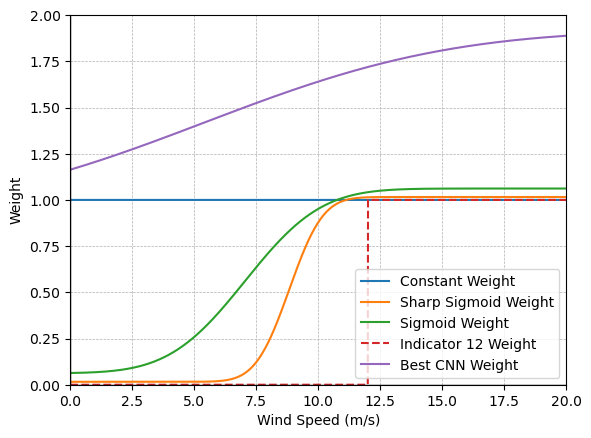

In [20]:
plt.plot(x, x_base, label='Constant Weight')
plt.plot(x, y_extreme, label='Sharp Sigmoid Weight')
plt.plot(x, y_intermediate, label='Sigmoid Weight')
plt.plot(x, y_ind12, label='Indicator 12 Weight', linestyle='--')
plt.plot(x, y_cnn, label='Best CNN Weight')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Weight')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(0, color='black',linewidth=1)
plt.axvline(0, color='black',linewidth=1)
plt.xlim(0,20)
plt.ylim(0, 2)
plt.legend()
plt.show()

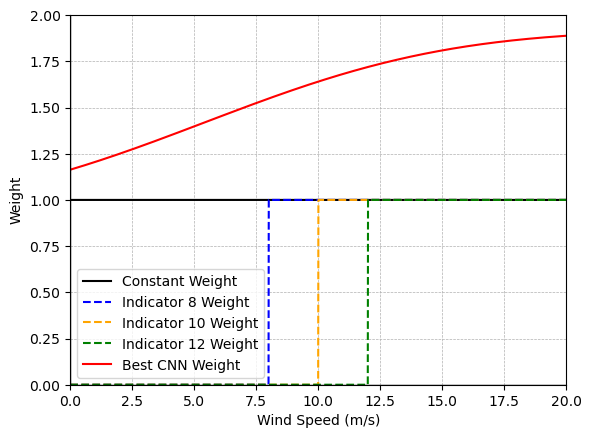

In [21]:
plt.plot(x, x_base, label='Constant Weight', color='black')
plt.plot(x, y_ind8, label='Indicator 8 Weight', linestyle='--', color='blue')
plt.plot(x, y_ind10, label='Indicator 10 Weight', linestyle='--', color='orange')
plt.plot(x, y_ind12, label='Indicator 12 Weight', linestyle='--', color='green')
plt.plot(x, y_cnn, label='Best CNN Weight', color='red')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Weight')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(0, color='black',linewidth=1)
plt.axvline(0, color='black',linewidth=1)
plt.xlim(0,20)
plt.ylim(0, 2)
plt.legend()
plt.show()

### Results on Test Data

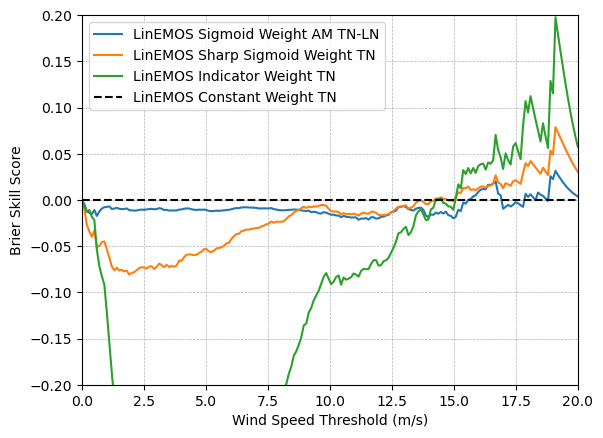

In [22]:
values = np.linspace(0,20,200)
ylim = [-0.2, 0.2]
make_brier_skill_plot(constant_weight_tn, all_linear_models_without_constant_weight0, test_data0, values, ylim=ylim, name_base_model='LinEMOS Constant Weight TN')

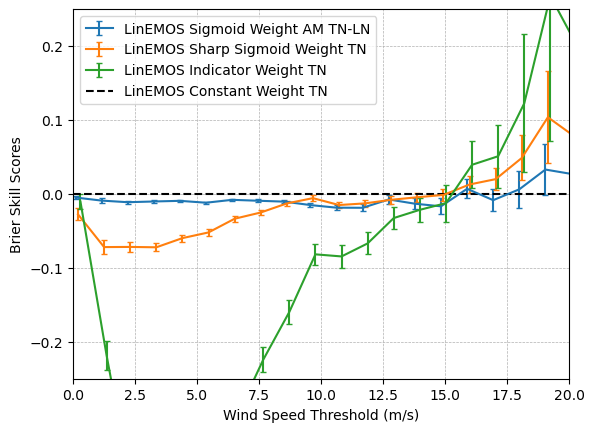

In [23]:
values = np.linspace(0,20,20)
ylim = [-0.25, 0.25]
make_bootstrap_brier(constant_weight_tn, all_linear_models_without_constant_weight0, test_data0, values,  ylim=ylim, name_base_model='LinEMOS Constant Weight TN', bootstrap_size=10000)

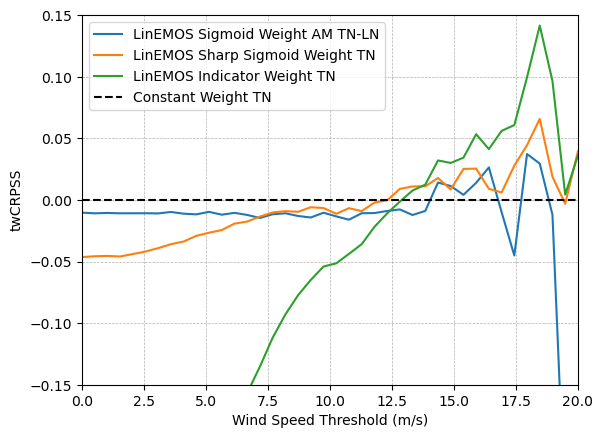

In [24]:
values = np.linspace(0,20,40)
ylim = [-0.15,0.15]
make_twcrpss_plot(constant_weight_tn, all_linear_models_without_constant_weight0, test_data0, values, ylim=ylim, base_model_name='Constant Weight TN', sample_size=2000)

There are 8671 values in the PIT diagram


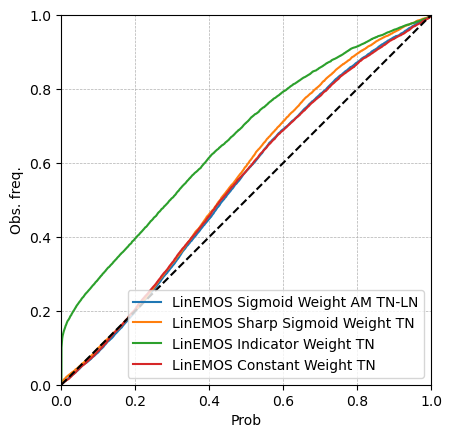

In [25]:
t = 0
make_cpit_diagram(all_linear_models_fold0, test_data0_original, t=t)

There are 265 values in the PIT diagram


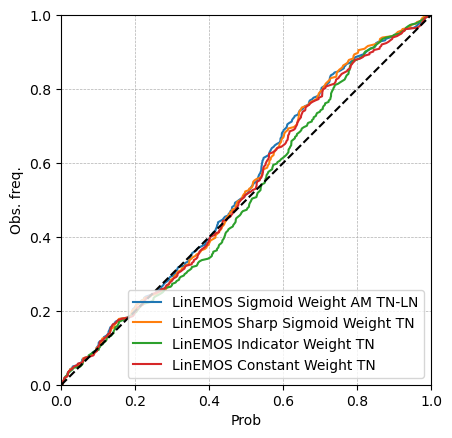

In [26]:
t = 12
make_cpit_diagram(all_linear_models_fold0, test_data0_original, t=t)

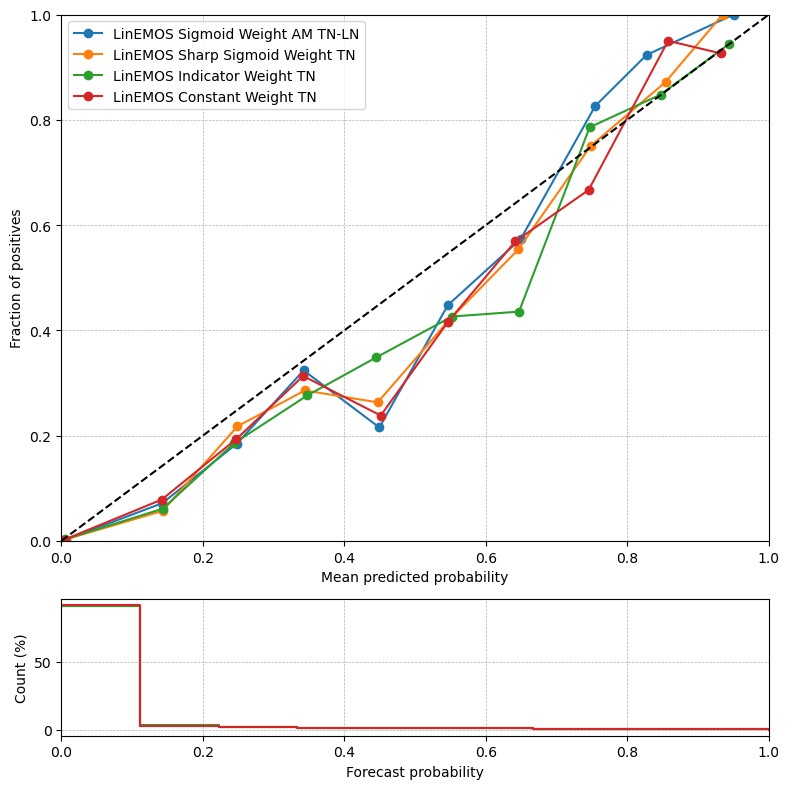

In [27]:
t = 12
make_reliability_and_sharpness(all_linear_models_fold0, test_data0, t=t)

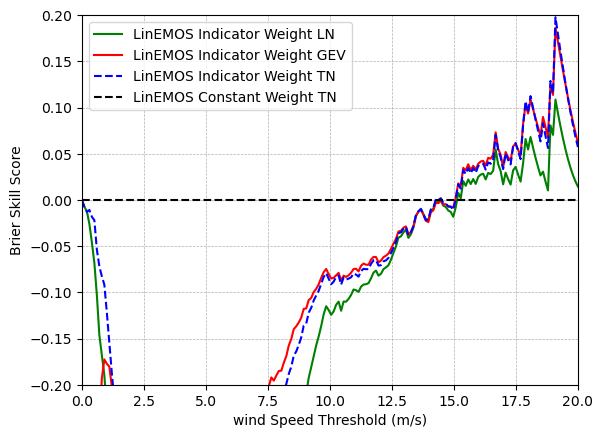

In [28]:
values = np.linspace(0,20,200)
ylim = [-0.2, 0.2]
basemodel = constant_weight_tn
data = test_data0
models = linear_models_different_distribution
name_base_model = 'LinEMOS Constant Weight TN'
title = None

brier_base_model = basemodel.Brier_Score(data, values)
for model in models:
    brier_scores = models[model].Brier_Score(data, values)
    brier_skill_scores = 1 - brier_scores / brier_base_model
    if 'TN' in model:
        linestyle = '--'
        color = 'blue'
    elif 'LN' in model:
        linestyle = '-'
        color = 'green'
    else:
        linestyle = '-'
        color = 'red'
    plt.plot(values, brier_skill_scores, label = model, linestyle=linestyle, color=color)

# print a striped black horizontal line at y=0
plt.axhline(0, color='black', linestyle='--', label=name_base_model)

plt.xlabel('wind Speed Threshold (m/s)')
plt.ylabel('Brier Skill Score')
if values[0] < 0.5:
    plt.xlim(0, values[-1])
else:
    plt.xlim(values[0], values[-1])
    
if ylim != None:
    plt.ylim(ylim[0], ylim[1])

if title is not None:
    plt.title(title)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

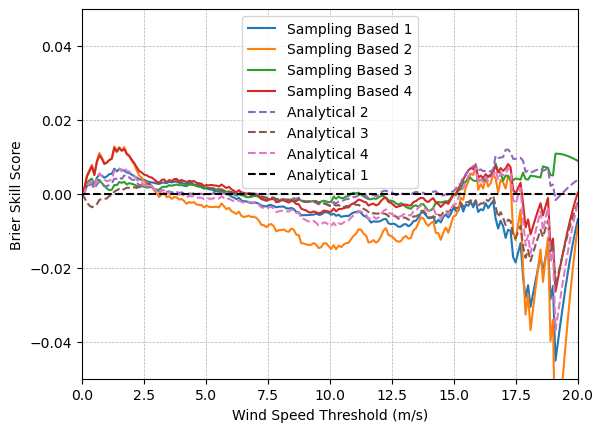

In [29]:
values = np.linspace(0,20,200)
ylim = [-0.05,0.05]
basemodel = emos_analytical
data = test_data0
title = None
models = sampling_based_models
name_base_model = "Analytical 1"

brier_base_model = basemodel.Brier_Score(data, values)
for model in models:
    brier_scores = models[model].Brier_Score(data, values)
    brier_skill_scores = 1 - brier_scores / brier_base_model
    if 'Analytical' in model:
        linestyle = '--'
    else:
        linestyle = '-'
    plt.plot(values, brier_skill_scores, label = model, linestyle=linestyle)

# print a striped black horizontal line at y=0
plt.axhline(0, color='black', linestyle='--', label=name_base_model)

plt.xlabel('Wind Speed Threshold (m/s)')
plt.ylabel('Brier Skill Score')
if values[0] < 0.5:
    plt.xlim(0, values[-1])
else:
    plt.xlim(values[0], values[-1])
    
if ylim != None:
    plt.ylim(ylim[0], ylim[1])

if title is not None:
    plt.title(title)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [30]:
X, y = next(iter(test_data0))
for model in sampling_based_models:
    print(model, sampling_based_models[model].CRPS_analytical(X['features_emos'], y).numpy().mean())

Sampling Based 1 0.8070297
Sampling Based 2 0.80979323
Sampling Based 3 0.8065323
Sampling Based 4 0.80548376
Analytical 2 0.8067603
Analytical 3 0.80665547
Analytical 4 0.8080821


### Results for Cross-Validation

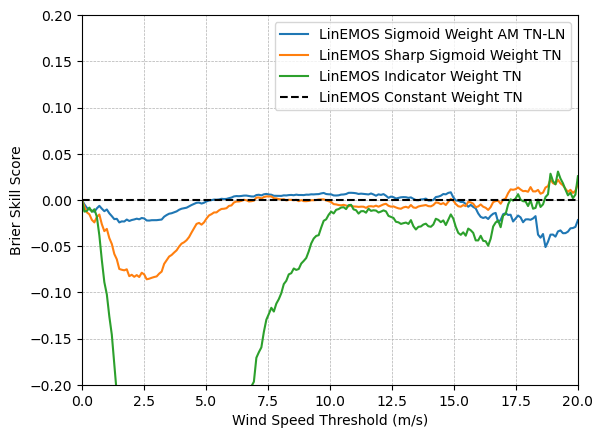

In [31]:
values = np.linspace(0,20,200)
ylim = [-0.2, 0.2]
make_brier_skill_plot(constant_weight_tn1, all_linear_models_without_constant_weight1, test_data1, values, ylim=ylim, name_base_model='LinEMOS Constant Weight TN')

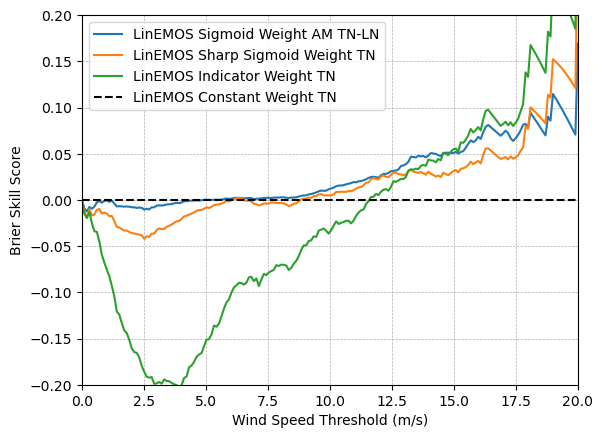

In [32]:
values = np.linspace(0,20,200)
ylim = [-0.2, 0.2]
make_brier_skill_plot(constant_weight_tn2, all_linear_models_without_constant_weight2, test_data2, values, ylim=ylim, name_base_model='LinEMOS Constant Weight TN')

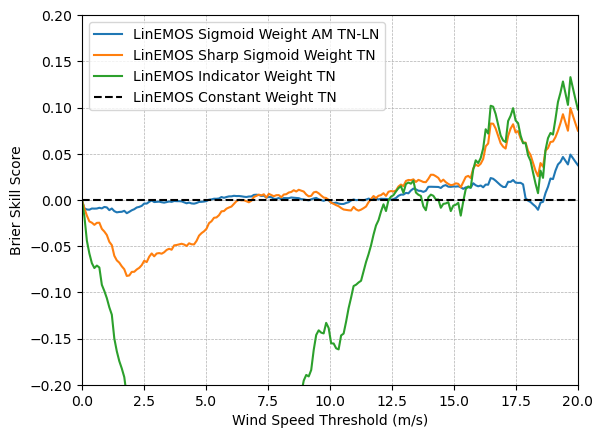

In [33]:
values = np.linspace(0,20,200)
ylim = [-0.2, 0.2]
make_brier_skill_plot(constant_weight_tn3, all_linear_models_without_constant_weight3, test_data3, values, ylim=ylim, name_base_model='LinEMOS Constant Weight TN')

### Results Single CNNEMOS

272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


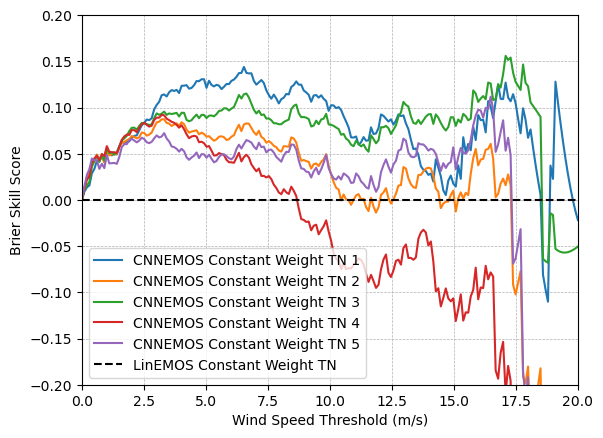

In [34]:
values = np.linspace(0,20,200)
ylim = [-0.2, 0.2]
make_brier_skill_plot(constant_weight_tn, single_cnn_constant_weight_dict, test_data0, values, ylim=ylim, name_base_model='LinEMOS Constant Weight TN')

### Results Bagging

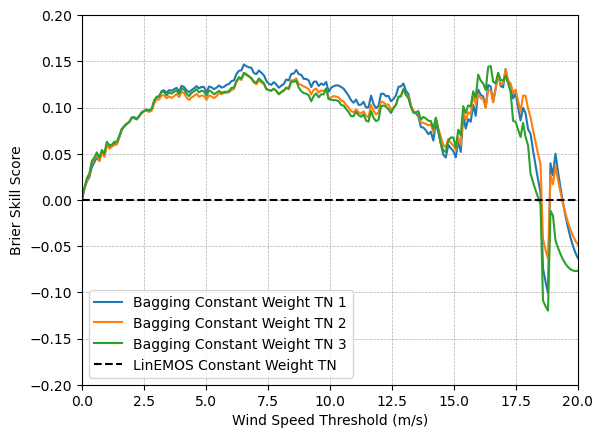

In [35]:
values = np.linspace(0,20,200)
ylim = [-0.2,0.2]
make_brier_skill_plot(constant_weight_tn, bagging_tn_crps_models, test_data0, values, ylim=ylim, name_base_model='LinEMOS Constant Weight TN')     

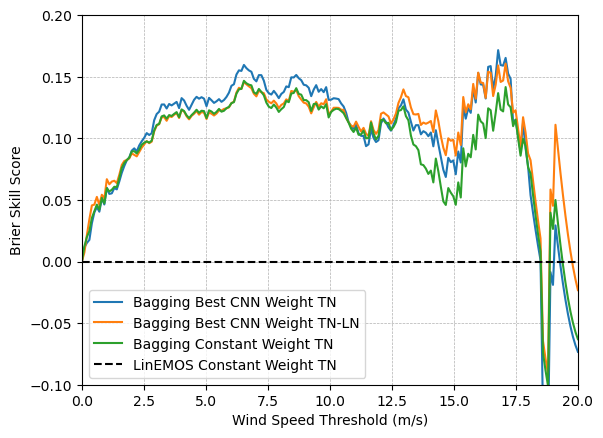

In [36]:
values = np.linspace(0,20,200)
ylim =[-0.1,0.2]
make_brier_skill_plot(constant_weight_tn, all_bagging_models, test_data0, values, ylim=ylim, name_base_model='LinEMOS Constant Weight TN')

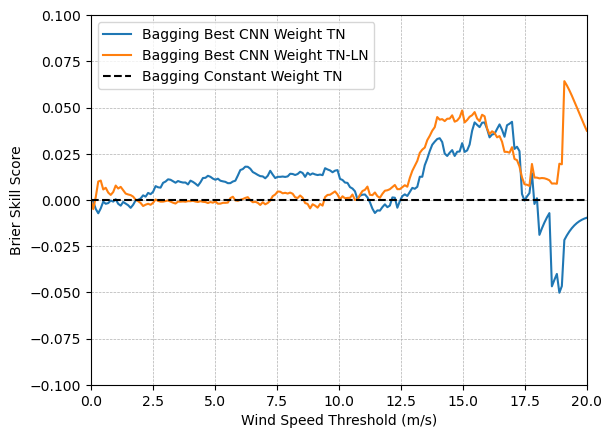

In [37]:
values = np.linspace(0,20,200)
ylim=[-0.1,0.1]
make_brier_skill_plot(bagging_tn_crps, all_bagging_models_without_constant_weight, test_data0, values=values, ylim=ylim, name_base_model='Bagging Constant Weight TN')

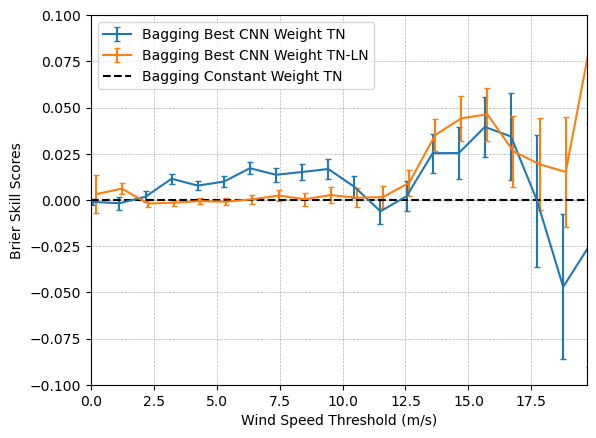

In [38]:
values = np.linspace(0,20,20)
ylim=[-0.1,0.1]
make_bootstrap_brier(bagging_tn_crps, all_bagging_models_without_constant_weight, test_data0, values=values, ylim=ylim, name_base_model='Bagging Constant Weight TN', bootstrap_size=10000)

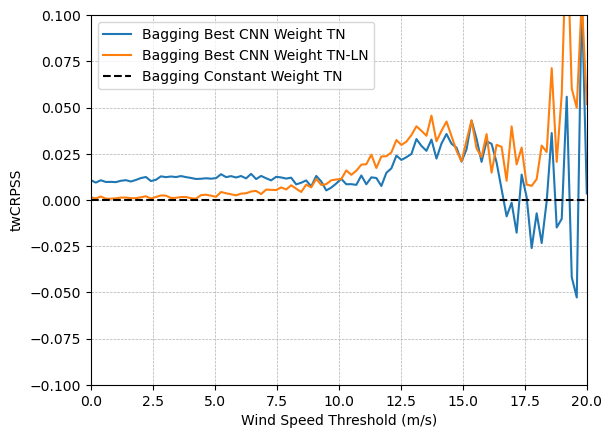

In [39]:
values = np.linspace(0,20,100)
ylim=[-0.1,0.1]
make_twcrpss_plot(bagging_tn_crps, all_bagging_models_without_constant_weight, test_data0, values, ylim=ylim, sample_size=200, base_model_name='Bagging Constant Weight TN')

There are 8671 values in the PIT diagram


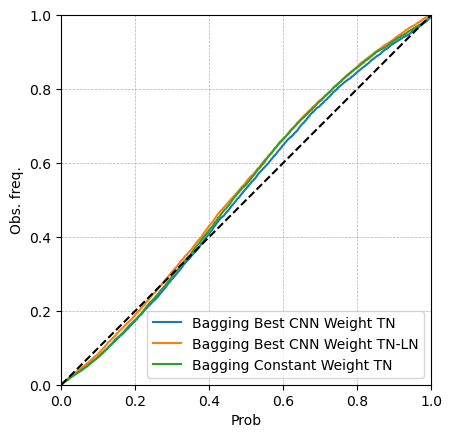

In [40]:
t = 0
make_cpit_diagram(all_bagging_models, test_data0_original, t=t)

There are 264 values in the PIT diagram


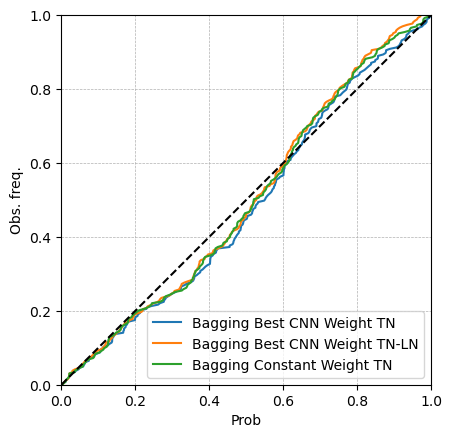

In [41]:
t = 12
make_cpit_diagram(all_bagging_models, test_data0_original, t=t)

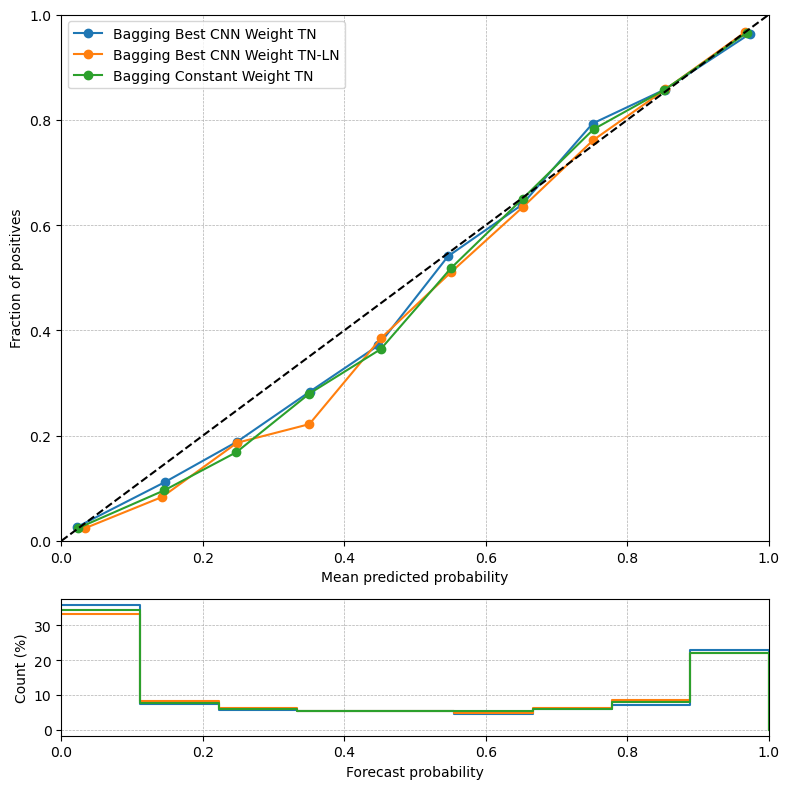

In [42]:
t = 5
make_reliability_and_sharpness(all_bagging_models, test_data0, t=t)

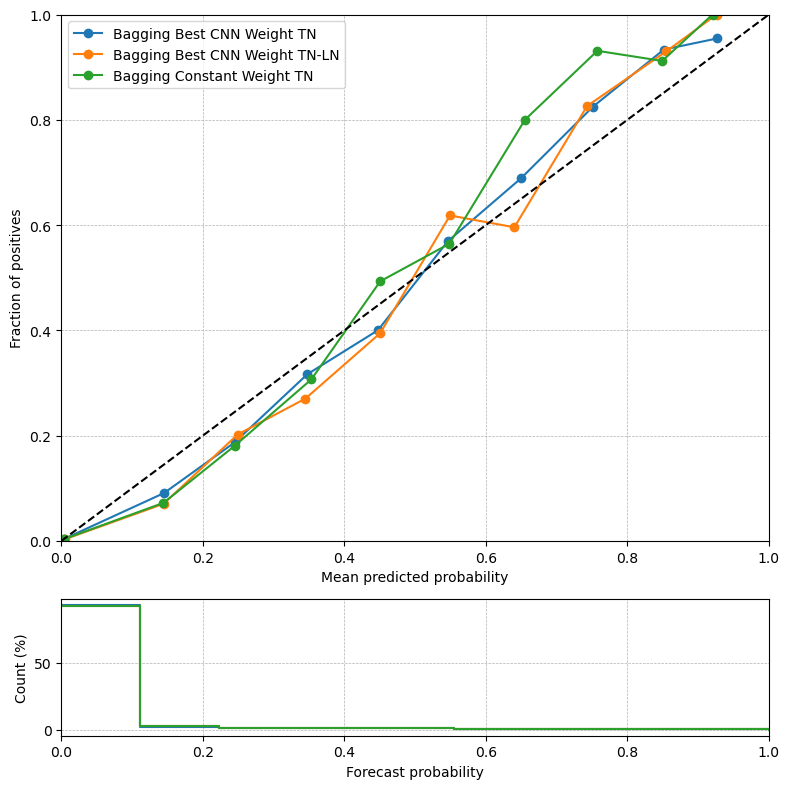

In [43]:
t = 12
make_reliability_and_sharpness(all_bagging_models, test_data0, t=t)

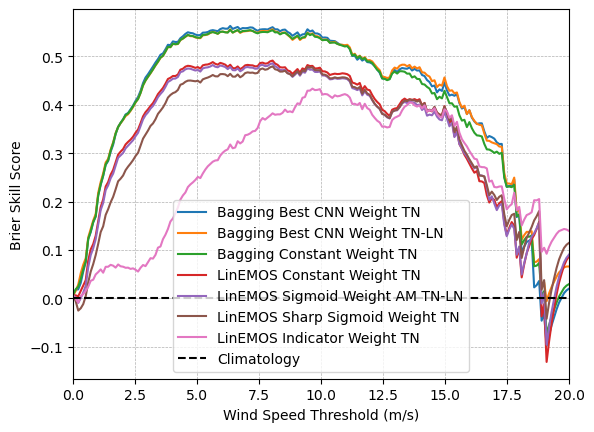

In [44]:
values = np.linspace(0.01,20,200)
make_brier_skill_plot(climatology, models_for_climatology, test_data0, values, name_base_model='Climatology')

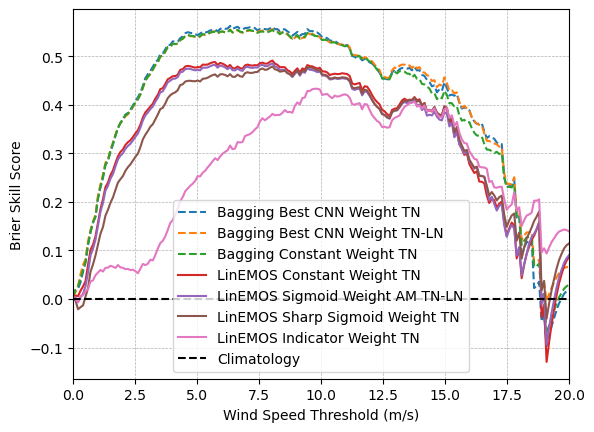

In [60]:
values = np.linspace(0.001, 20, 200)
basemodel = climatology
ylim = None
name_base_model = 'Climatology'
title = None

brier_base_model = basemodel.Brier_Score(test_data0, values)
for model in models_for_climatology:
    brier_scores = models_for_climatology[model].Brier_Score(test_data0, values)
    brier_skill_scores = 1 - brier_scores / brier_base_model
    if 'Bagging' in model:
        linestyle = 'dashed'
    else:
        linestyle = 'solid'
    plt.plot(values, brier_skill_scores, label = model, linestyle=linestyle)

# print a striped black horizontal line at y=0
plt.axhline(0, color='black', linestyle='--', label=name_base_model)

plt.xlabel('Wind Speed Threshold (m/s)')
plt.ylabel('Brier Skill Score')
if values[0] < 0.5:
    plt.xlim(0, values[-1])
else:
    plt.xlim(values[0], values[-1])
    
if ylim != None:
    plt.ylim(ylim[0], ylim[1])

if title is not None:
    plt.title(title)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

### Bagging Cross-Validation

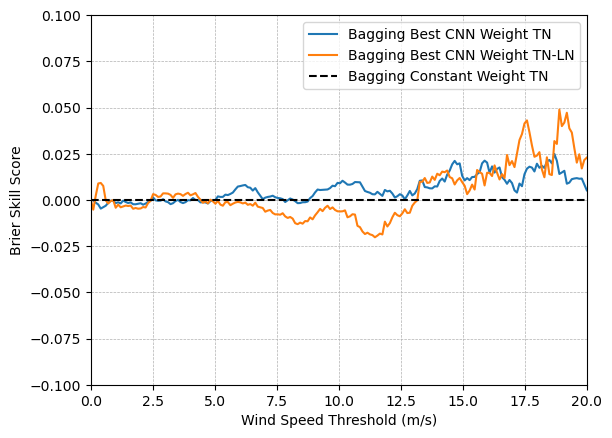

In [49]:
values = np.linspace(0,20,200)
ylim=[-0.1,0.1]
make_brier_skill_plot(bagging_tn_crps_f1, all_bagging_models_without_constant_weight_f1, test_data1, values=values, ylim=ylim, name_base_model='Bagging Constant Weight TN')

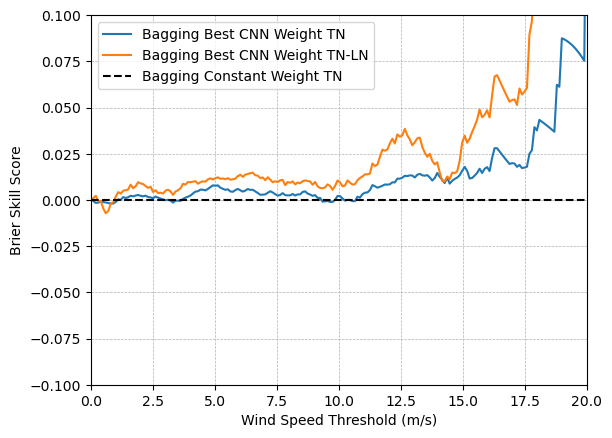

In [50]:
values = np.linspace(0,20,200)
ylim=[-0.1,0.1]
make_brier_skill_plot(bagging_tn_crps_f2, all_bagging_models_without_constant_weight_f2, test_data2, values=values, ylim=ylim, name_base_model='Bagging Constant Weight TN')

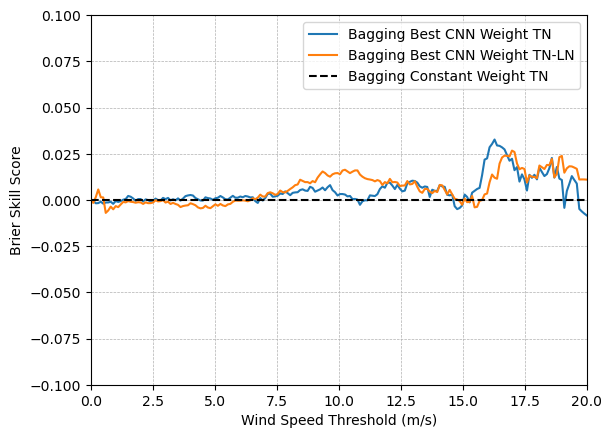

In [51]:
values = np.linspace(0,20,200)
ylim=[-0.1,0.1]
make_brier_skill_plot(bagging_tn_crps_f3, all_bagging_models_without_constant_weight_f3, test_data3, values=values, ylim=ylim, name_base_model='Bagging Constant Weight TN')

### Weigt of the Mixture CNNs

 29/272 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


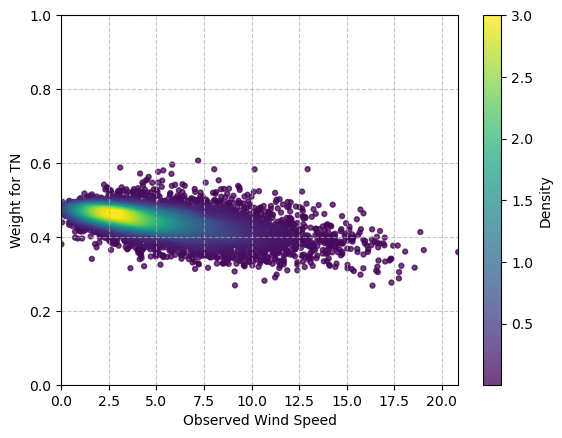

In [52]:
plot_weight_mixture_cnns(bagging_best_cnn_weight_tn_ln.models[5], test_data0)

 29/272 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


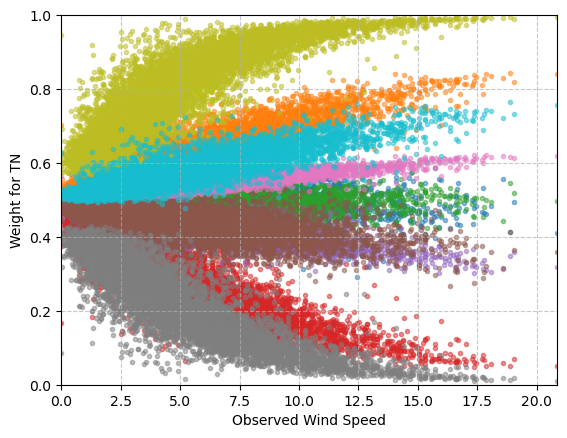

In [53]:
plot_weight_mixture_bagging(bagging_best_cnn_weight_tn_ln, test_data0, False)

### PDFs of Bagging models

In [54]:
X, y = next(iter(test_data0))

predictions = []

for model in bagging_tn_crps.models:
    predictions.append(model.predict(X))


 14/272 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [55]:
X_forecast = X['wind_speed_forecast']

In [56]:
sample_number = 10
distributions = []
for i, prediction in enumerate(predictions):
    distribution = bagging_tn_crps.models[i].get_distribution(prediction)
    distributions.append(distribution)

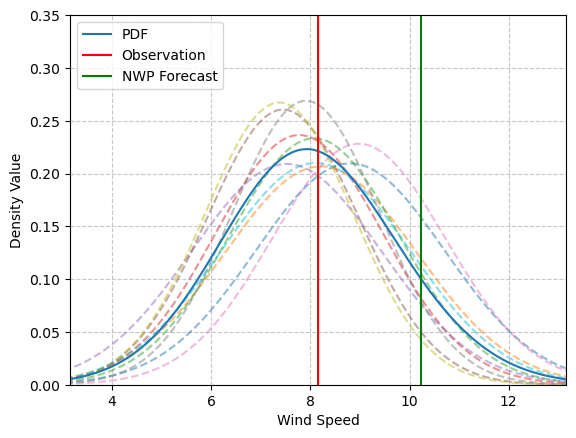

In [57]:
x = np.linspace(0,20,200)
value = 3813# 314#1012
averages = np.zeros(shape=(10, 200))
for i, distribution in enumerate(distributions):
    distribution_values = distribution[value].prob(x)
    plt.plot(x, distribution_values, linestyle='--', alpha=0.5)
    averages[i,:] = distribution_values

plt.plot(x, averages.mean(axis=0), label='PDF')

plt.grid(True, linestyle='--', alpha=0.7)
plt.ylabel('Density Value')
plt.xlabel('Wind Speed')
plt.axvline(y[value], color = 'red', label = 'Observation')
plt.axvline(X_forecast[value], color='green', label='NWP Forecast')
xminval = np.max([0, y[value]-5])
plt.xlim(xminval, y[value] + 5)
plt.ylim(0,0.35)
plt.legend()
plt.show()


In [58]:
def truncated_normal_pdf(x, mean, variance, lower_bound, upper_bound):
    stddev = np.sqrt(variance)
    a, b = (lower_bound - mean) / stddev, (upper_bound - mean) / stddev  # Truncation bounds in standardized form
    return truncnorm.pdf(x, a, b, loc=mean, scale=stddev)

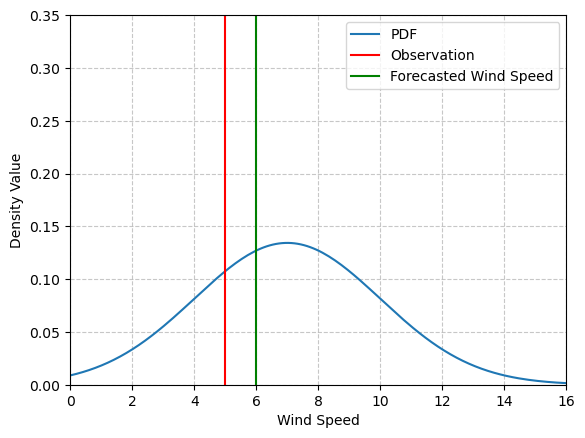

In [59]:
x = np.linspace(0,20,200)
mean = 7
sigma = 9
pdf_values = truncated_normal_pdf(x, mean, sigma, 0, 1000)

value = 314
averages = np.zeros(shape=(10, 200))

plt.plot(x, pdf_values, label='PDF')

plt.grid(True, linestyle='--', alpha=0.7)
plt.ylabel('Density Value')
plt.xlabel('Wind Speed')
plt.axvline(5, color = 'red', label = 'Observation')
plt.axvline(6, color='green', label='Forecasted Wind Speed')
xminval = np.max([0, y[value]-5])
plt.xlim(0, 16)
plt.ylim(0,0.35)
plt.legend()
plt.show()